# ICD-10 CM Code Analysis

This notebook provides a comprehensive analysis of the ICD-10 Clinical Modification (CM) codes, focusing on:
- Overall trie structure and metrics
- Chapter distribution
- Hierarchy depth analysis
- Example code exploration
- Search tools for both tabular and alphabetic indexes
- Coding guidelines

In [28]:
import sys
sys.path.append('..')  # Add parent directory to path

from icd_codes.icd import ICD10Trie
from icd_codes.models import Code, CmCode, PcsCode, Term, Category, CmCategory
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import numpy as np

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("Loading ICD-10 trie...")
trie = ICD10Trie.from_cms(year=2025, use_update=False)
trie.parse()
print("✓ Trie loaded successfully!")

Loading ICD-10 trie...


Downloaded ICD version 2025 successfully!

 Following files will be parsed: ['2025-official-icd-10-pcs-coding-guidelines.pdf', 
'fy-2025-icd-10-cm-coding-guidelines.pdf', 'icd10pcs_tables_2025.xml', 'icd10pcs_index_2025.xml', 
'icd10cm_tabular_2025.xml', 'icd10cm_neoplasm_2025.xml', 'icd10cm_index_2025.xml', 'icd10cm_eindex_2025.xml', 
'icd10cm_drug_2025.xml'] 

Output()

Output()

Output()

Output()

✓ Trie loaded successfully!


## 0. Overall Structure of the Trie

High-level overview of the ICD-10 trie structure with key metrics.

### ICD-10 Trie Data Model Structure

The ICD-10 Trie is a hierarchical tree data structure that organizes medical codes and their relationships. It consists of several key components:

---

#### 1. Main Data Structures

The Trie class contains 5 main dictionaries:

- **`tabular: dict[str, Code]`**
  - Hierarchical tree of ICD codes organized by official classification
  - Maps internal IDs → Code/Category objects
  
- **`lookup: dict[str, str]`**
  - Fast access mapping: code names → internal IDs
  - Example: `"E11.22"` → internal ID
  
- **`index: dict[str, Term]`**
  - Alphabetic index for clinical term lookup
  - Maps internal IDs → Term objects
  
- **`index_lookup: dict[str, str]`**
  - Fast access mapping: term titles → internal IDs
  
- **`guidelines: dict[str, Guideline]`**
  - Coding guidelines organized by chapter

---

#### 2. Hierarchical Model Classes

```
Root (Base Class)
├─ id: str                    # Internal unique identifier
├─ name: str                  # Display name (e.g., "E11.22")
├─ min: str                   # Minimum code in range
├─ max: str                   # Maximum code in range
├─ assignable: bool           # Can be assigned to patient?
├─ parent_id: str             # Link to parent node
└─ children_ids: list[str]    # Links to child nodes

    ↓ (inherits from Root)

Category (Container Node)
├─ All Root fields
├─ description: str           # Human-readable description
└─ assignable: False          # Categories are NOT assignable

    ↓ (inherits from Category)

Code (Leaf/Assignable Node)
├─ All Category fields
└─ assignable: True           # Codes ARE assignable to patients
```

---

#### 3. CM-Specific Classes (Clinical Modification)

```
CmCategory (Category + InstructionalNote)
├─ All Category fields
├─ notes: list[str]                # Clinical notes
├─ includes: list[str]             # What this code includes
├─ inclusion_term: list[str]       # Inclusion terms
├─ excludes1: list[str]            # Cannot be coded together
├─ excludes2: list[str]            # Not included here
├─ use_additional_code: list[str]  # Additional codes to use
├─ code_first: list[str]           # Code this condition first
└─ code_also: list[str]            # Also code these conditions

    ↓ (inherits from CmCategory)

CmCode (Final Assignable Code)
├─ All CmCategory fields
├─ assignable: True
├─ etiology: bool              # Is this an underlying cause?
└─ manifestation: bool         # Is this a manifestation of another disease?
```

---

#### 4. Alphabetic Index Model

```
Term (Index Entry)
├─ id: str                         # Internal identifier
├─ title: str                      # Term text (e.g., "Diabetes")
├─ code: str | None                # ICD code this term points to
├─ manifestation_code: str | None  # Secondary manifestation code
├─ see: str | None                 # Cross-reference
├─ see_also: str | None            # Additional cross-reference
├─ parent_id: str                  # Link to parent term
├─ children_ids: list[str]         # Links to subterms
└─ assignable: bool                # Has direct code reference?
```

---

#### 5. Hierarchy Example (Tabular)

```
Root: "cm" (Clinical Modification)
  │
  └─ Chapter: "4" (Endocrine, nutritional and metabolic diseases E00-E89)
      │
      └─ Block: "E08-E13" (Diabetes mellitus)
          │
          └─ Category: "E11" (Type 2 diabetes mellitus)
              │
              ├─ Subcategory: "E11.2" (with kidney complications)
              │   │
              │   └─ Code: "E11.22" (with diabetic chronic kidney disease) ✓ ASSIGNABLE
              │
              └─ Subcategory: "E11.3" (with ophthalmic complications)
                  └─ ...
```

---

#### 6. Hierarchy Example (Alphabetic Index)

```
Main Term: "Diabetes"
  │
  ├─ Subterm: "with"
  │   │
  │   └─ Sub-subterm: "chronic kidney disease" → Code: E11.22
  │
  └─ Subterm: "type 2"
      └─ Sub-subterm: "with kidney complications" → Code: E11.2-
```

---

#### 7. Key Relationships

- **`parent_id` + `children_ids`**: Create the tree structure
- **`lookup` dictionary**: Enables fast code name → object retrieval
- **Tabular vs Index**: Two different ways to navigate to the same codes
  - **Tabular**: Navigate by code structure (E00 → E11 → E11.2 → E11.22)
  - **Index**: Navigate by clinical terms (Diabetes → kidney → chronic)
- **`assignable` flag**: Distinguishes leaf nodes (codes) from containers (categories)
- **CM codes** include rich metadata (instructional notes) for proper coding

## 1. Trie Structure

Understanding the data model and architecture of the ICD-10 Trie.

In [29]:
# Calculate metrics
cm_codes = 0
pcs_codes = 0
cm_assignable = 0
pcs_assignable = 0
cm_categories = 0
pcs_categories = 0

for code_id, code_obj in trie.tabular.items():
    # Determine if CM or PCS by checking the root
    is_cm = isinstance(code_obj, (CmCode, CmCategory))
    is_pcs = isinstance(code_obj, (PcsCode))
    
    if is_cm:
        cm_codes += 1
        if getattr(code_obj, 'assignable', False):
            cm_assignable += 1
        elif isinstance(code_obj, Category):
            cm_categories += 1
    elif is_pcs:
        pcs_codes += 1
        if getattr(code_obj, 'assignable', False):
            pcs_assignable += 1
        elif isinstance(code_obj, Category):
            pcs_categories += 1

# Print metrics
print("=" * 70)
print("ICD-10 TRIE STRUCTURE OVERVIEW")
print("=" * 70)
print(f"\n📊 Root Systems: {len(trie.roots)}")
print(f"   Roots: {', '.join(trie.roots)}")
print(f"\n📖 Tabular Hierarchy:")
print(f"   Total nodes: {len(trie.tabular):,}")
print(f"\n   CM (Clinical Modification):")
print(f"      Total nodes: {cm_codes:,}")
print(f"      Categories: {cm_categories:,}")
print(f"      Assignable codes: {cm_assignable:,}")
print(f"\n   PCS (Procedure Coding System):")
print(f"      Total nodes: {pcs_codes:,}")
print(f"      Categories: {pcs_categories:,}")
print(f"      Assignable codes: {pcs_assignable:,}")
print(f"\n🔍 Alphabetic Index:")
print(f"   Total terms: {len(trie.index):,}")
print(f"   Main terms: {len(trie.get_all_main_terms()):,}")
print(f"\n📚 Guidelines:")
print(f"   Chapters with guidelines: {len(trie.guidelines)}")
print(f"\n🔑 Lookup Tables:")
print(f"   Code name → ID mappings: {len(trie.lookup):,}")
print(f"   Index term mappings: {len(trie.index_lookup):,}")
print("=" * 70)

ICD-10 TRIE STRUCTURE OVERVIEW

📊 Root Systems: 2
   Roots: pcs, cm

📖 Tabular Hierarchy:
   Total nodes: 180,557

   CM (Clinical Modification):
      Total nodes: 97,978
      Categories: 23,566
      Assignable codes: 74,412

   PCS (Procedure Coding System):
      Total nodes: 78,986
      Categories: 0
      Assignable codes: 78,986

🔍 Alphabetic Index:
   Total terms: 150,684
   Main terms: 13,592

📚 Guidelines:
   Chapters with guidelines: 26

🔑 Lookup Tables:
   Code name → ID mappings: 176,647
   Index term mappings: 142,108


In [30]:
# Visualize tree structure example (limited depth and width)
def visualize_tree_structure(start_code_id, max_depth=3, max_children=3):
    """Visualize a limited portion of the tree structure."""
    
    def print_node(code_id, depth=0, prefix="", is_last=True):
        if depth > max_depth:
            return
        
        code_obj = trie.tabular[code_id]
        
        # Node formatting
        connector = "└── " if is_last else "├── "
        if depth == 0:
            connector = ""
        
        code_name = getattr(code_obj, 'name', code_id)
        code_desc = getattr(code_obj, 'description', 'No description')[:50]
        is_assignable = getattr(code_obj, 'assignable', False)
        marker = "✓" if is_assignable else "○"
        
        print(f"{prefix}{connector}{marker} [{code_name}] {code_desc}")
        
        # Prepare prefix for children
        new_prefix = prefix + ("    " if is_last else "│   ") if depth > 0 else ""
        
        # Show limited children
        if code_obj.children_ids and depth < max_depth:
            children = code_obj.children_ids[:max_children]
            remaining = len(code_obj.children_ids) - len(children)
            
            for i, child_id in enumerate(children):
                is_last_child = (i == len(children) - 1) and (remaining == 0)
                print_node(child_id, depth + 1, new_prefix, is_last_child)
            
            if remaining > 0:
                ellipsis = new_prefix + "└── "
                print(f"{ellipsis}... and {remaining} more")
    
    print("\n" + "=" * 70)
    print("EXAMPLE TREE STRUCTURE (Limited View)")
    print("=" * 70 + "\n")
    print_node(start_code_id)
    print("\n" + "=" * 70)
    print("Legend: ✓ = Assignable code, ○ = Category/Non-assignable")
    print(f"Showing max {max_depth} levels deep, {max_children} children per node")
    print("=" * 70 + "\n")

# Visualize from CM root
visualize_tree_structure('cm', max_depth=3, max_children=3)


EXAMPLE TREE STRUCTURE (Limited View)

○ [cm] No description
├── ○ [1] Certain infectious and parasitic diseases (A00-B99
│   ├── ○ [A00-A09] Intestinal infectious diseases (A00-A09)
│   │   ├── ○ [A00] Cholera
│   │   ├── ✓ [A00.0] Cholera due to Vibrio cholerae 01, biovar cholerae
│   │   ├── ✓ [A00.1] Cholera due to Vibrio cholerae 01, biovar eltor
│   │   └── ... and 91 more
│   ├── ○ [A00] Cholera
│   │   ├── ✓ [A00.0] Cholera due to Vibrio cholerae 01, biovar cholerae
│   │   ├── ✓ [A00.1] Cholera due to Vibrio cholerae 01, biovar eltor
│   │   └── ✓ [A00.9] Cholera, unspecified
│   ├── ✓ [A00.0] Cholera due to Vibrio cholerae 01, biovar cholerae
│   └── ... and 1326 more
├── ○ [A00-A09] Intestinal infectious diseases (A00-A09)
│   ├── ○ [A00] Cholera
│   │   ├── ✓ [A00.0] Cholera due to Vibrio cholerae 01, biovar cholerae
│   │   ├── ✓ [A00.1] Cholera due to Vibrio cholerae 01, biovar eltor
│   │   └── ✓ [A00.9] Cholera, unspecified
│   ├── ✓ [A00.0] Cholera due to Vibrio chole

## 2. Chapter Distribution

Overview of ICD-10 CM chapters and the number of assignable codes in each.


ICD-10 CM Chapters by Number of Assignable Codes:
Total Chapters: 22

Chapter   Range                                                                                                   Description  Assignable Codes
      1 A00-B99                                                           Certain infectious and parasitic diseases (A00-B99)              1067
      2 C00-D49                                                                                           Neoplasms (C00-D49)              1724
      3 D50-D89 Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism (D50-D89)               321
      4 E00-E89                                                       Endocrine, nutritional and metabolic diseases (E00-E89)               956
      5 F01-F99                                                 Mental, Behavioral and Neurodevelopmental disorders (F01-F99)               871
      6 G00-G99                                                  

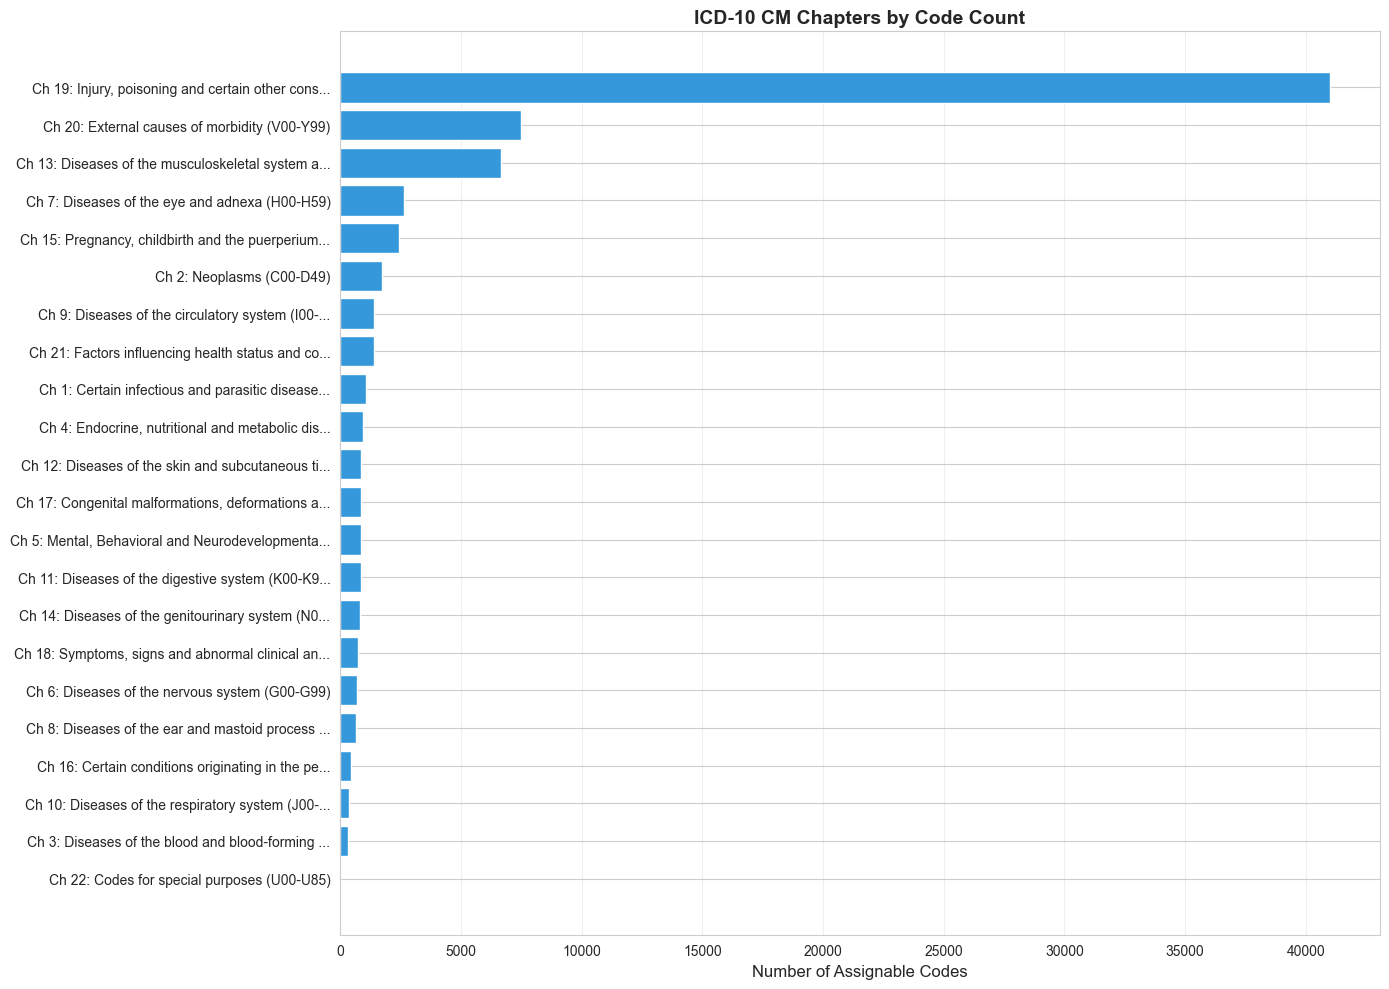

In [31]:
# Get all CM chapters (direct children of 'cm' root that are chapters only)
cm_root = trie.tabular['cm']
chapters = []

# Helper function to count assignable codes recursively (without double counting)
def count_assignable(code_id, visited=None):
    """Recursively count unique assignable codes under a given node."""
    if visited is None:
        visited = set()
    
    code_obj = trie.tabular[code_id]

    # Count this code if assignable and not already visited
    if getattr(code_obj, 'assignable', False) and code_id not in visited:
        visited.add(code_id)

    # Recurse through children
    for child_id in code_obj.children_ids:
        count_assignable(child_id, visited)

    return len(visited)

# Only get chapter-level categories
# Chapters are categories with numeric names like "1", "2", "3", etc.
# NOT ranges like "S60-S69" (those are blocks within chapters)
for chapter_id in cm_root.children_ids:
    chapter_obj = trie.tabular[chapter_id]

    # Only include if this is a chapter (numeric name, not a range)
    # Chapters have names like "1", "2", "3" not "A00-B99"
    if isinstance(chapter_obj, Category) and not getattr(chapter_obj, 'assignable', False):
        # Check if name is numeric (chapter) vs a range (block)
        if chapter_obj.name.isdigit():
            assignable_count = count_assignable(chapter_id)

            chapters.append({
                'Chapter': chapter_obj.name,
                'Range': f"{chapter_obj.min}-{chapter_obj.max}",
                'Description': chapter_obj.description,
                'Assignable Codes': assignable_count
            })

# Create DataFrame and sort by chapter number
df_chapters = pd.DataFrame(chapters)
df_chapters['Chapter_Num'] = df_chapters['Chapter'].astype(int)
df_chapters = df_chapters.sort_values('Chapter_Num').drop('Chapter_Num', axis=1)

print("\nICD-10 CM Chapters by Number of Assignable Codes:")
print(f"Total Chapters: {len(df_chapters)}\n")
print(df_chapters.to_string(index=False))

print(f"\nTotal assignable codes across all chapters: {df_chapters['Assignable Codes'].sum():,}")

# Visualize - sort by code count for the chart
df_chapters_sorted = df_chapters.sort_values('Assignable Codes', ascending=True)

plt.figure(figsize=(14, 10))
plt.barh(range(len(df_chapters_sorted)), df_chapters_sorted['Assignable Codes'].values, color='#3498db')
plt.yticks(range(len(df_chapters_sorted)),
           [f"Ch {row['Chapter']}: {row['Description'][:40]}..." if len(row['Description']) > 40
            else f"Ch {row['Chapter']}: {row['Description']}"
            for _, row in df_chapters_sorted.iterrows()])
plt.xlabel('Number of Assignable Codes', fontsize=12)
plt.title('ICD-10 CM Chapters by Code Count', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. CM Hierarchy Depth (Tabular)

Distribution of hierarchy depth for CM codes to understand how deep the classification goes.


CM Hierarchy Depth Distribution:
Depth      All Nodes       Assignable Only
----------------------------------------
1          22              0              
2          296             0              
3          1,917           280            
4          10,262          5,592          
5          17,924          10,532         
6          27,407          17,858         
7          40,150          40,150         

Average depth (all CM nodes): 5.95
Average depth (assignable only): 6.24
Maximum depth: 7


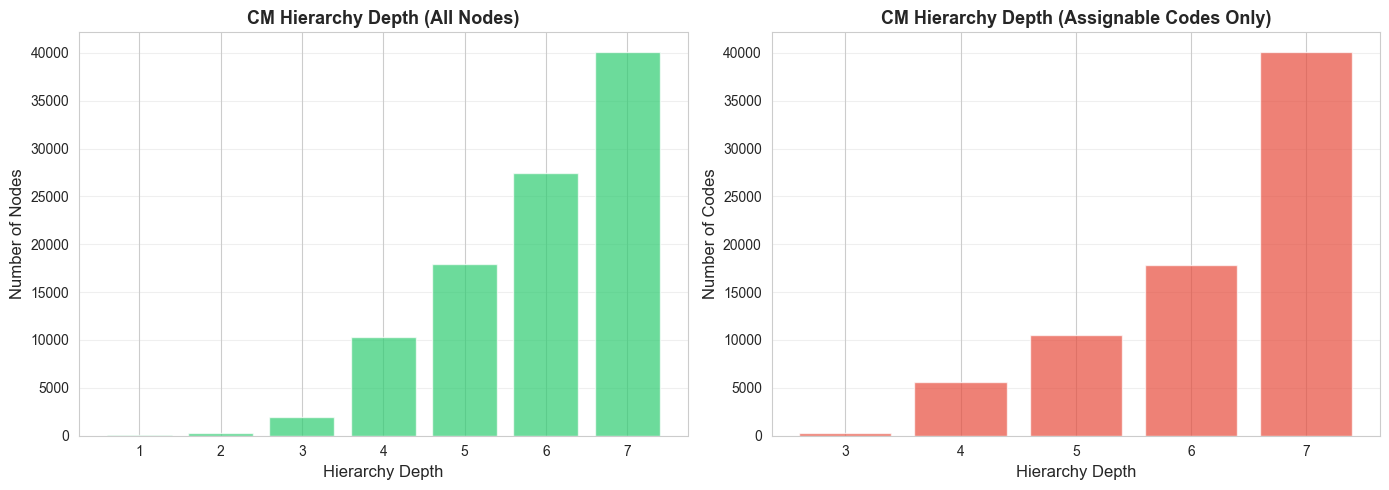

In [32]:
# Calculate depth for all CM codes
def get_depth(code_id):
    """Calculate depth of a code in the hierarchy."""
    depth = 0
    current = trie.tabular[code_id]
    while current.parent_id:
        current = trie.tabular[current.parent_id]
        depth += 1
    return depth

cm_depths = []
cm_assignable_depths = []

for code_id, code_obj in trie.tabular.items():
    if isinstance(code_obj, (CmCode, CmCategory)):
        depth = get_depth(code_id)
        cm_depths.append(depth)
        
        if getattr(code_obj, 'assignable', False):
            cm_assignable_depths.append(depth)

# Analyze depth distribution
depth_counter = Counter(cm_depths)
assignable_depth_counter = Counter(cm_assignable_depths)

print("\nCM Hierarchy Depth Distribution:")
print(f"{'Depth':<10} {'All Nodes':<15} {'Assignable Only':<15}")
print("-" * 40)
for depth in sorted(depth_counter.keys()):
    print(f"{depth:<10} {depth_counter[depth]:<15,} {assignable_depth_counter.get(depth, 0):<15,}")

print(f"\nAverage depth (all CM nodes): {np.mean(cm_depths):.2f}")
print(f"Average depth (assignable only): {np.mean(cm_assignable_depths):.2f}")
print(f"Maximum depth: {max(cm_depths)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All nodes
depths = sorted(depth_counter.keys())
counts = [depth_counter[d] for d in depths]
axes[0].bar(depths, counts, color='#2ecc71', alpha=0.7)
axes[0].set_xlabel('Hierarchy Depth', fontsize=12)
axes[0].set_ylabel('Number of Nodes', fontsize=12)
axes[0].set_title('CM Hierarchy Depth (All Nodes)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Assignable only
depths = sorted(assignable_depth_counter.keys())
counts = [assignable_depth_counter[d] for d in depths]
axes[1].bar(depths, counts, color='#e74c3c', alpha=0.7)
axes[1].set_xlabel('Hierarchy Depth', fontsize=12)
axes[1].set_ylabel('Number of Codes', fontsize=12)
axes[1].set_title('CM Hierarchy Depth (Assignable Codes Only)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. CM Example Code (Tabular)

Detailed exploration of a specific assignable CM code.

In [33]:
# Example: Type 2 diabetes with diabetic chronic kidney disease
example_code = "E11.22"  # This is an assignable code

if example_code in trie.lookup:
    code_id = trie.lookup[example_code]
    code_obj = trie[example_code]
    
    print("=" * 70)
    print(f"EXAMPLE CM CODE: {example_code}")
    print("=" * 70)
    print(f"\nDescription: {code_obj.description}")
    print(f"Type: {type(code_obj).__name__}")
    print(f"Assignable: {'✓ Yes' if code_obj.assignable else '✗ No'}")
    
    # Show hierarchy path
    def visualize_code_hierarchy(code_id, max_siblings=3):
        """Visualize the full path from root to this code with limited siblings."""
        
        # Get all parents
        path = []
        current_id = code_id
        while current_id:
            path.append(current_id)
            current_obj = trie.tabular[current_id]
            current_id = current_obj.parent_id
        
        path.reverse()  # Root to leaf
        
        print("\n" + "=" * 70)
        print("HIERARCHY PATH")
        print("=" * 70 + "\n")
        
        for i, node_id in enumerate(path):
            node = trie.tabular[node_id]
            indent = "  " * i
            
            # Mark if this is our target code
            marker = "✓" if getattr(node, 'assignable', False) else "○"
            is_target = (node_id == code_id)
            target_mark = " ⬅ TARGET" if is_target else ""
            
            node_name = getattr(node, 'name', node_id)
            node_desc = getattr(node, 'description', 'No description')
            
            print(f"{indent}{marker} [{node_name}] {node_desc}{target_mark}")
            
            # Show siblings (limited) if not at target
            if i < len(path) - 1:  # Not the last level
                next_in_path = path[i + 1]
                siblings = [s for s in node.children_ids if s != next_in_path]
                
                if siblings:
                    shown_siblings = siblings[:max_siblings]
                    for sib_id in shown_siblings:
                        sib = trie.tabular[sib_id]
                        sib_marker = "✓" if getattr(sib, 'assignable', False) else "○"
                        sib_name = getattr(sib, 'name', sib_id)
                        sib_desc = getattr(sib, 'description', 'No description')[:45]
                        print(f"{indent}  {sib_marker} [{sib_name}] {sib_desc}...")
                    
                    if len(siblings) > max_siblings:
                        print(f"{indent}  ... and {len(siblings) - max_siblings} more siblings")
        
        print("\n" + "=" * 70)
    
    visualize_code_hierarchy(code_id, max_siblings=2)
    
    # Show all metadata and instructional notes
    print("\n" + "=" * 70)
    print("CODE METADATA & INSTRUCTIONAL NOTES")
    print("=" * 70)
    
    if hasattr(code_obj, 'notes') and code_obj.notes:
        print("\n📝 Notes:")
        for note in code_obj.notes:
            print(f"  • {note}")
    
    if hasattr(code_obj, 'includes') and code_obj.includes:
        print("\n📌 Includes:")
        for item in code_obj.includes:
            print(f"  • {item}")
    
    if hasattr(code_obj, 'inclusion_term') and code_obj.inclusion_term:
        print("\n📌 Inclusion Terms:")
        for item in code_obj.inclusion_term:
            print(f"  • {item}")
    
    if hasattr(code_obj, 'excludes1') and code_obj.excludes1:
        print("\n🚫 Excludes1 (Not coded here):")
        for item in code_obj.excludes1:
            print(f"  • {item}")
    
    if hasattr(code_obj, 'excludes2') and code_obj.excludes2:
        print("\n⚠️  Excludes2 (Not included here):")
        for item in code_obj.excludes2:
            print(f"  • {item}")
    
    if hasattr(code_obj, 'use_additional_code') and code_obj.use_additional_code:
        print("\n➕ Use Additional Code:")
        for item in code_obj.use_additional_code:
            print(f"  • {item}")
    
    if hasattr(code_obj, 'code_first') and code_obj.code_first:
        print("\n1️⃣  Code First:")
        for item in code_obj.code_first:
            print(f"  • {item}")
    
    if hasattr(code_obj, 'code_also') and code_obj.code_also:
        print("\n🔗 Code Also:")
        for item in code_obj.code_also:
            print(f"  • {item}")
    
    if hasattr(code_obj, 'etiology'):
        print(f"\n🔬 Etiology: {code_obj.etiology}")
    
    if hasattr(code_obj, 'manifestation'):
        print(f"🔬 Manifestation: {code_obj.manifestation}")
    
    print("\n" + "=" * 70)
    
else:
    print(f"Code {example_code} not found")

EXAMPLE CM CODE: E11.22

Description: Type 2 diabetes mellitus with diabetic chronic kidney disease
Type: CmCode
Assignable: ✓ Yes

HIERARCHY PATH

○ [cm] No description
  ○ [1] Certain infectious and parasitic diseases (A0...
  ○ [A00-A09] Intestinal infectious diseases (A00-A09)...
  ... and 97975 more siblings
  ○ [4] Endocrine, nutritional and metabolic diseases (E00-E89)
    ○ [E00-E07] Disorders of thyroid gland (E00-E07)...
    ○ [E00] Congenital iodine-deficiency syndrome...
    ... and 1249 more siblings
    ○ [E08-E13] Diabetes mellitus (E08-E13)
      ○ [E08] Diabetes mellitus due to underlying condition...
      ○ [E08.0] Diabetes mellitus due to underlying condition...
      ... and 578 more siblings
      ○ [E11] Type 2 diabetes mellitus
        ○ [E11.0] Type 2 diabetes mellitus with hyperosmolarity...
        ✓ [E11.00] Type 2 diabetes mellitus with hyperosmolarity...
        ... and 112 more siblings
        ○ [E11.2] Type 2 diabetes mellitus with kidney complications


## 5. Search Code (Tabular)

Search for CM codes in the tabular hierarchy by code name or description.

In [34]:
def search_cm_tabular(query, assignable_only=True, limit=20):
    """
    Search CM codes in the tabular hierarchy.
    
    Args:
        query: Search term (searches in code name and description)
        assignable_only: If True, only show assignable codes
        limit: Maximum number of results to display
    """
    query_lower = query.lower()
    results = []
    all_matches = 0  # Count all matches, not just displayed ones
    
    for code_id, code_obj in trie.tabular.items():
        # Only CM codes
        if not isinstance(code_obj, (CmCode, CmCategory)):
            continue
        
        # Filter by assignable
        if assignable_only and not getattr(code_obj, 'assignable', False):
            continue
        
        # Search in name and description
        code_name = getattr(code_obj, 'name', '').lower()
        code_desc = getattr(code_obj, 'description', '').lower()
        
        if query_lower in code_name or query_lower in code_desc:
            all_matches += 1
            
            # Only add to results if under limit
            if len(results) < limit:
                results.append({
                    'Code': getattr(code_obj, 'name', code_id),
                    'Description': getattr(code_obj, 'description', 'No description'),
                    'Assignable': '✓' if getattr(code_obj, 'assignable', False) else '○'
                })
    
    if results:
        df_results = pd.DataFrame(results)
        print(f"\nFound {all_matches:,} total results for '{query}' (showing first {len(results)}):")
        print("=" * 100)
        print(df_results.to_string(index=False))
        print("=" * 100)
        if all_matches > limit:
            print(f"\n(Showing {limit} of {all_matches:,} total matches. Adjust 'limit' parameter to see more.)")
    else:
        print(f"No results found for '{query}'")
    
    return results

# Example searches
print("Example 1: Search for 'diabetes'")
search_cm_tabular('diabetes', assignable_only=True, limit=15)

print("\n" + "="*100)
print("\nExample 2: Search for 'fracture'")
search_cm_tabular('fracture', assignable_only=True, limit=10)

Example 1: Search for 'diabetes'

Found 486 total results for 'diabetes' (showing first 15):
    Code                                                                                                                        Description Assignable
  E08.00      Diabetes mellitus due to underlying condition with hyperosmolarity without nonketotic hyperglycemic-hyperosmolar coma (NKHHC)          ✓
  E08.01                                                       Diabetes mellitus due to underlying condition with hyperosmolarity with coma          ✓
  E08.10                                                       Diabetes mellitus due to underlying condition with ketoacidosis without coma          ✓
  E08.11                                                          Diabetes mellitus due to underlying condition with ketoacidosis with coma          ✓
  E08.21                                                            Diabetes mellitus due to underlying condition with diabetic nephropathy          ✓
 

[{'Code': 'K08.530',
  'Description': 'Fractured dental restorative material without loss of material',
  'Assignable': '✓'},
 {'Code': 'K08.531',
  'Description': 'Fractured dental restorative material with loss of material',
  'Assignable': '✓'},
 {'Code': 'K08.539',
  'Description': 'Fractured dental restorative material, unspecified',
  'Assignable': '✓'},
 {'Code': 'M48.40XA',
  'Description': 'Fatigue fracture of vertebra, site unspecified (initial encounter for fracture)',
  'Assignable': '✓'},
 {'Code': 'M48.40XD',
  'Description': 'Fatigue fracture of vertebra, site unspecified (subsequent encounter for fracture with routine healing)',
  'Assignable': '✓'},
 {'Code': 'M48.40XG',
  'Description': 'Fatigue fracture of vertebra, site unspecified (subsequent encounter for fracture with delayed healing)',
  'Assignable': '✓'},
 {'Code': 'M48.40XS',
  'Description': 'Fatigue fracture of vertebra, site unspecified (sequela of fracture)',
  'Assignable': '✓'},
 {'Code': 'M48.41XA',
  

## 6. Search Code (Alphabetic)

Search for CM codes using the alphabetic index (how clinicians look up codes by condition/symptom).

In [35]:
def search_cm_alphabetic(query, limit=20):
    """
    Search CM codes in the alphabetic index.
    
    Args:
        query: Search term (searches in term titles)
        limit: Maximum number of results to display
    """
    query_lower = query.lower()
    results = []
    all_matches = 0  # Count all matches, not just displayed ones
    
    for term_id, term_obj in trie.index.items():
        # Search in term title
        term_title = term_obj.title.lower()
        
        if query_lower in term_title:
            all_matches += 1
            
            # Only add to results if under limit
            if len(results) < limit:
                # Build full path
                path_parts = [term_obj.title]
                current = term_obj
                while current.parent_id:
                    current = trie.index.get(current.parent_id)
                    if current:
                        path_parts.insert(0, current.title)
                    else:
                        break
                
                path = " → ".join(path_parts)
                code_str = term_obj.code if term_obj.code else "(no direct code)"
                
                # Get see/see also references
                refs = []
                if term_obj.see:
                    refs.append(f"See: {term_obj.see}")
                if term_obj.see_also:
                    refs.append(f"See also: {term_obj.see_also}")
                ref_str = " | ".join(refs) if refs else ""
                
                results.append({
                    'Term Path': path,
                    'Code': code_str,
                    'References': ref_str
                })
    
    if results:
        df_results = pd.DataFrame(results)
        print(f"\nFound {all_matches:,} total results for '{query}' in alphabetic index (showing first {len(results)}):")
        print("=" * 120)
        for i, row in df_results.iterrows():
            print(f"\n{i+1}. {row['Term Path']}")
            print(f"   Code: {row['Code']}")
            if row['References']:
                print(f"   {row['References']}")
        print("\n" + "=" * 120)
        if all_matches > limit:
            print(f"\n(Showing {limit} of {all_matches:,} total matches. Adjust 'limit' parameter to see more.)")
    else:
        print(f"No results found for '{query}'")
    
    return results

# Example searches
print("Example 1: Search for 'pneumonia'")
search_cm_alphabetic('pneumonia', limit=15)

print("\n" + "="*120)
print("\nExample 2: Search for 'hypertension'")
search_cm_alphabetic('hypertension', limit=10)

Example 1: Search for 'pneumonia'

Found 101 total results for 'pneumonia' in alphabetic index (showing first 15):

1. Abscess → lung → with pneumonia
   Code: J85.1

2. Abscess → lung → amebic → with → pneumonia
   Code: A06.5

3. Actinomycosis, actinomycotic → with pneumonia
   Code: A42.0

4. Allergy, allergic → pneumonia
   Code: J82.89

5. Anthrax → with pneumonia
   Code: A22.1

6. Ascariasis → with → pneumonia, pneumonitis
   Code: B77.81

7. Aspiration → amniotic fluid → with → pneumonia
   Code: P24.11

8. Aspiration → blood → newborn → with → pneumonia
   Code: P24.21

9. Aspiration → liquor → with → pneumonia
   Code: P24.11

10. Aspiration → milk → with → pneumonia
   Code: P24.31

11. Aspiration → mucus → newborn → with → pneumonia
   Code: P24.11

12. Aspiration → neonatal → specific NEC → with → pneumonia
   Code: P24.81

13. Aspiration → newborn → specific NEC → with → pneumonia
   Code: P24.81

14. Aspiration → pneumonia
   Code: J69.0

15. Aspiration → vernix caseosa 

[{'Term Path': 'Albuminuria, albuminuric → complicating pregnancy → with → gestational hypertension',
  'Code': '(no direct code)',
  'References': 'See: Pre-eclampsia'},
 {'Term Path': 'Albuminuria, albuminuric → complicating pregnancy → with → pre-existing hypertension',
  'Code': '(no direct code)',
  'References': 'See: Hypertension, complicating pregnancy, pre-existing, with, pre-eclampsia'},
 {'Term Path': 'Albuminuria, albuminuric → gestational → with → gestational hypertension',
  'Code': '(no direct code)',
  'References': 'See: Pre-eclampsia'},
 {'Term Path': 'Albuminuria, albuminuric → gestational → with → pre-existing hypertension',
  'Code': '(no direct code)',
  'References': 'See: Hypertension, complicating pregnancy, pre-existing, with, pre-eclampsia'},
 {'Term Path': 'Blood → pressure → high → incidental reading, without diagnosis of hypertension',
  'Code': 'R03.0',
  'References': ''},
 {'Term Path': 'Borderline → hypertension', 'Code': 'R03.0', 'References': ''},
 {

## 7. Guidelines

Sample of coding guidelines to understand their structure and content.

In [36]:
# Show a sample guideline
print("=" * 70)
print("ICD-10 CM CODING GUIDELINES SAMPLE")
print("=" * 70)

if trie.guidelines:
    # Get first few guidelines
    sample_guidelines = list(trie.guidelines.items())[:3]
    
    for i, (guideline_id, guideline) in enumerate(sample_guidelines, 1):
        print(f"\n{'='*70}")
        print(f"Guideline {i}")
        print(f"{'='*70}")
        print(f"ID: {guideline.id}")
        print(f"Number: {guideline.number}")
        print(f"Title: {guideline.title}")
        print(f"\nContent (first 500 characters):")
        print("-" * 70)
        content_preview = guideline.content[:500]
        print(content_preview)
        if len(guideline.content) > 500:
            print(f"\n... (truncated, {len(guideline.content) - 500} more characters)")
        print("-" * 70)
    
    print(f"\n{'='*70}")
    print(f"Total guidelines available: {len(trie.guidelines)}")
    print(f"{'='*70}")
    
else:
    print("No guidelines found in trie.")

ICD-10 CM CODING GUIDELINES SAMPLE

Guideline 1
ID: section_I_A
Number: IA
Title: A. Conventions for the ICD‑10‑CM

Content (first 500 characters):
----------------------------------------------------------------------
A. Conventions for the ICD-10-CM 
The conventions for the ICD-10-CM are the general rules for use of the classification 
independent of the guidelines. These conventions are incorporated within the Alphabetic Index 
and Tabular List of the ICD-10-CM as instructional notes. 
1. 
The Alphabetic Index and Tabular List 
The ICD-10-CM is divided into the Alphabetic Index, an alphabetical list of terms and 
their corresponding code, and the Tabular List, a structured list of codes divided into 
chapte

... (truncated, 13289 more characters)
----------------------------------------------------------------------

Guideline 2
ID: section_I_B
Number: IB
Title: B. General Coding Guidelines

Content (first 500 characters):
------------------------------------------------------------

## Interactive Tools

Use the search functions defined above to explore the data:

```python
# Search tabular codes
search_cm_tabular('your_query', assignable_only=True, limit=20)

# Search alphabetic index
search_cm_alphabetic('your_query', limit=20)
```